#### 隨機產生args....!!!

In [243]:
import os 
from time import time
from random import uniform, randint

import pandas as pd 
import numpy  as np 
import torch
import matplotlib.pyplot as plt 

from tqdm import tqdm

from utils import load_mch
from utils.mch import MCHHandler

from utils.kde import smooth

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
wl = [i for i in range(660, 921, 10)]
%matplotlib inline

In [244]:
x_range = {
    "idx": None,
    "skin_b": (0.0012, 0.0041),
    "skin_s": (0.985, 1.0),
    "skin_w": (0.166, 0.261),
    "skin_f": (0.187, 0.277),
    "skin_m": (0.0087, 0.0165),

    "fat_f": (0.5, 1),

    "muscle_b": (0.005, 0.050),
    "muscle_s": (0.5, 0.9),
    "muscle_w": (0.5, 0.9),

    "ijv_s": (0.0, 1.0),

    "cca_s": (0.0, 1.0),
}
x_range = {
    "idx": None,
    "sb": (0, 0.1),
    "ss": (0.9, 1.0),
    "sw": (0, 1.0),
    "sf": (0, 0.5),
    "sm": (0, 0.5),

    "ff": (1, 1),

    "mb": (0.005, 0.1),
    "ms": (0.0, 1.0),
    "mw": (0.0, 1.0),

    "is": (0.4, 0.8),

    "cs": (0.85, 1.0),
}

In [257]:
x_range = {
    "idx": None,
    "sb": (0, 0.1),
    "ss": (0.9, 1.0),
    "sw": (0, 1.0),
    "sf": (0, 0.5),
    "sm": (0, 0.5),

    "ff": (1, 1),

    "mb": (0.005, 0.1),
    "ms": (0.0, 1.0),
    "mw": (0.0, 1.0),

    "is": (0.4, 0.8),

    "cs": (0.85, 1.0),
}
def get_args(xrange, num=50000):
    args = []
    for i in range(num):
        sb = uniform(x_range["sb"][0], x_range["sb"][1])
        ss = uniform(x_range["ss"][0], x_range["ss"][1])
        sw = uniform(x_range["sw"][0], max(x_range["sw"][0], min(x_range["sw"][1], 1-sb)))
        sf = uniform(x_range["sf"][0], max(x_range["sf"][0], min(x_range["sf"][1], 1-sb-sw)))
        sm = 1-sb-sw-sf
        mb = uniform(x_range["mb"][0], x_range["mb"][1])
        ms = uniform(x_range["ms"][0], x_range["ms"][1])
        mw = uniform(x_range["mw"][0], max(x_range["mw"][0], min(x_range["mw"][1], 1-mb)))
        mc = 1 - mb - mw
        is_ = uniform(x_range["is"][0], x_range["is"][1])
        cs = uniform(x_range["cs"][0], x_range["cs"][1])
        arg = {
            "skin":{
                "blood_volume_fraction": sb,
                "ScvO2": ss,
                "water_volume": sw,
                "fat_volume": sf,
                "melanin_volume": sm,
                "collagen_colume": 0
            },

            "fat":{
                "blood_volume_fraction": 0,
                "ScvO2": 0,
                "water_volume": 0,
                "fat_volume": 1,
                "melanin_volume": 0,
                "collagen_colume": 0
            },

            "muscle":{
                "blood_volume_fraction": mb,
                "ScvO2": ms,
                "water_volume": mw,
                "fat_volume": 0,
                "melanin_volume": 0,
                "collagen_colume": mc
            },
            "ijv":{
                "blood_volume_fraction": 1,
                "ScvO2": is_,
                "water_volume": 0,
                "fat_volume": 0,
                "melanin_volume": 0,
                "collagen_colume": 0
            },
            "cca":{
                "blood_volume_fraction": 1,
                "ScvO2": cs,
                "water_volume": 0,
                "fat_volume": 0,
                "melanin_volume": 0,
                "collagen_colume": 0
            },
        }
        args += [arg]
    
    return args

args = get_args(x_range)

#### 跑WMC!!

In [258]:
idx = "20190527"
idx = os.path.join("configs", "live", idx)
max_no_prism = idx + "_max" + "_no_prism" + ".json"
max_prism = idx + "_max" + ".json"
min_no_prism = idx + "_min" + "_no_prism" + ".json"
min_prism = idx + "_min" + ".json"

In [5]:
mch = MCHHandler()

In [247]:
mch.load_config(max_no_prism)
s_max, r_max = mch.run_wmc(args)

In [266]:
mch.load_config(min_no_prism)
s_min, r_min = mch.run_wmc(args)

In [136]:
mch.load_config(max_no_prism)

In [16]:
# # mch.mch_list[0]
d, head, _ = mch._load_mch(mch.mch_list[10])
head

{'version': 1,
 'maxmedia': 5,
 'detnum': 3,
 'colcount': 13,
 'total_photon': 2000000000,
 'detected': 776458,
 'saved_photon': 776458,
 'unitmm': 0.25,
 'seed_byte': 0,
 'normalize': 1.600000023841858,
 'respin': 1}

In [75]:
d.groupby("detector_idx").mean().values

array([[ 27.60124738,  14.12332015,  63.50165299,  10.78716826,
          2.04508379,  -0.68077417],
       [ 30.79733374,  14.96717536,  84.14615171,  18.99216843,
          3.58556873,  -0.68189089],
       [ 32.71829191,  15.53809413, 107.64298238,  29.69513384,
          5.26234759,  -0.68373827]])

In [137]:
dd = []
dd_std = []
for mh in mch.mch_list:
    d, _, _ = mch._load_mch(mh)
    dd += [d.groupby("detector_idx").mean().values]
    dd_std += [d.groupby("detector_idx").std().values]
    
dd = np.asarray(dd)
dd_std = np.asarray(dd_std)

dd.shape # (27, 3, 6)


(20, 3, 6)

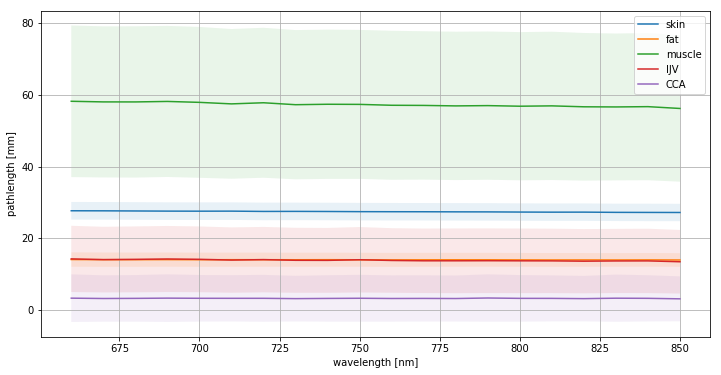

In [140]:
plt.figure(figsize=(12, 6))
tissue = ["skin", "fat", "muscle", "IJV", "CCA"]
for i in range(5):
    plt.plot(wl[:20], dd[:20, 0, i], label=tissue[i])
    plt.fill_between(
        wl[:20], 
        dd[:20, 0, i] - dd_std[:20, 0, i] * 0.2,
        dd[:20, 0, i] + dd_std[:20, 0, i] * 0.2,
        alpha=0.1
    )
plt.legend()
plt.grid()
plt.xlabel("wavelength [nm]")
plt.ylabel("pathlength [mm]")
plt.show()

In [ ]:
d.groupby("detector_idx").mean()

#### 活體光譜

In [270]:
# df = pd.read_csv("data/calibrated/20190507/IJV/20190507_1_1.csv")
# df = pd.read_csv("data/calibrated/20190502/IJV/20190502_1_1.csv")
# df = pd.read_csv("data/calibrated/20190510/IJV/20190510_1_1.csv")
# df = pd.read_csv("data/calibrated/20190511/IJV/20190511_1_1.csv")
# df = pd.read_csv("data/calibrated/20190524_split/IJV/20190524_7_1.csv")





# df = pd.read_csv("data/calibrated/20190524_split/IJV/20190524_split_4_1.csv")
# df = pd.read_csv("data/calibrated/20190524_split/IJV/20190524_split_4_2.csv")
# df = pd.read_csv("data/calibrated/20190524_split/IJV/20190524_split_4_3.csv")

# df = pd.read_csv("data/calibrated/20190524_split/IJV/20190524_split_7_1.csv")
# df = pd.read_csv("data/calibrated/20190524_split/IJV/20190524_split_7_2.csv")
# df = pd.read_csv("data/calibrated/20190524_split/IJV/20190524_split_7_3.csv")

df = pd.read_csv("data/calibrated/20190527_split/IJV/20190527_split_2_1.csv")
# df = pd.read_csv("data/calibrated/20190527_split/IJV/20190527_split_2_2.csv")
# df = pd.read_csv("data/calibrated/20190527_split/IJV/20190527_split_2_3.csv")

#### 比較波型和強度

#### 未加凌鏡

num: 0 | loss: 0.9891971049837258


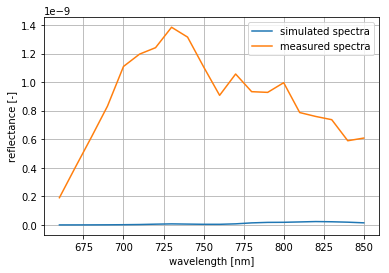

num: 3 | loss: 0.9246802380698558


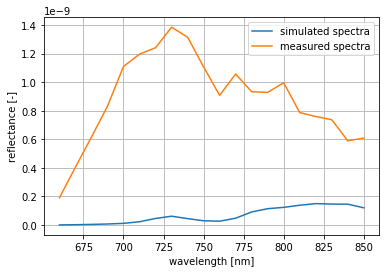

num: 8 | loss: 0.8186524506794016


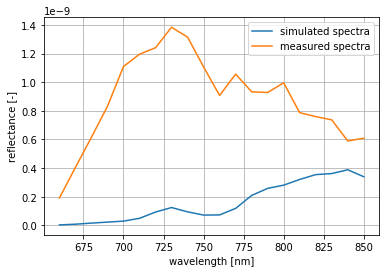

num: 29 | loss: 0.738236531814945


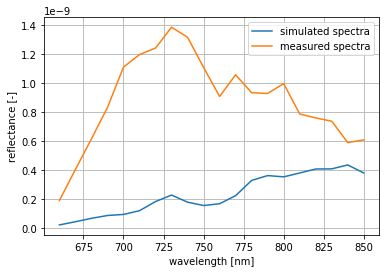

num: 38 | loss: 0.6107937188323701


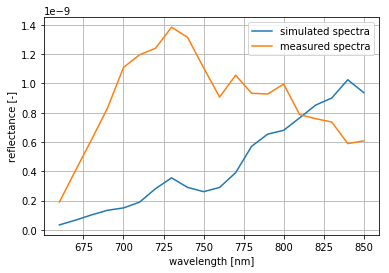

num: 51 | loss: 0.6052826804278796


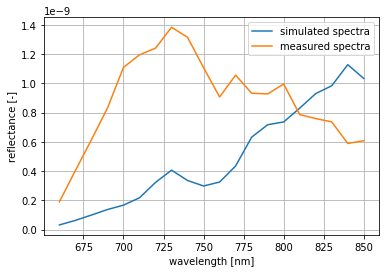

num: 106 | loss: 0.5412871038607658


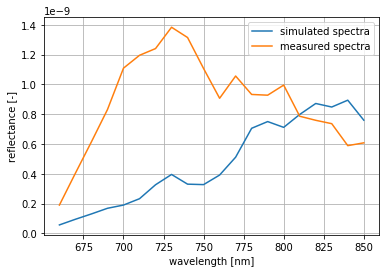

num: 440 | loss: 0.5289309145530091


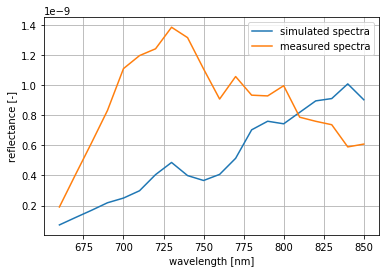

num: 1589 | loss: 0.528696918754992


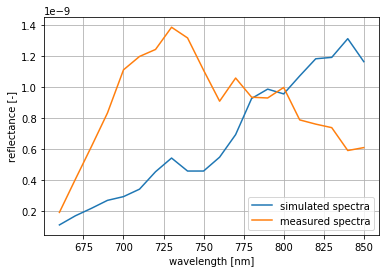

num: 1614 | loss: 0.509037800536421


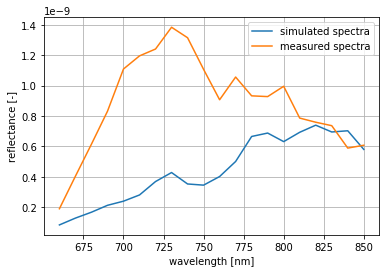

num: 1635 | loss: 0.5067018995532503


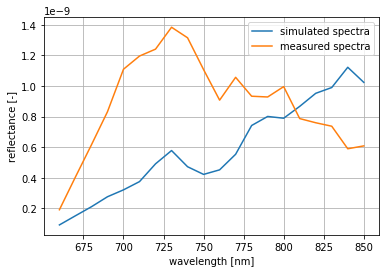

num: 1737 | loss: 0.5043818306465391


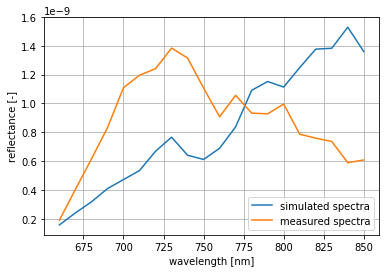

num: 2665 | loss: 0.4580496116155978


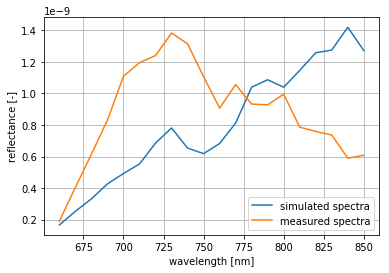

num: 9158 | loss: 0.43392009844968954


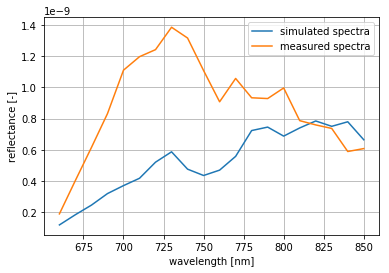

num: 12766 | loss: 0.4273742350283621


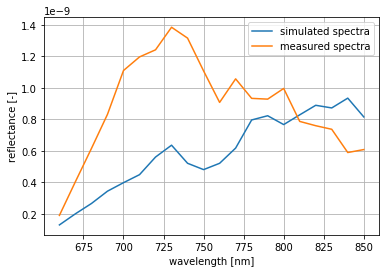

In [271]:
# IJV舒張
loss = 100
for i, s in enumerate(s_min):
    s = smooth(s[0, :20], 0.8)
    live = df["max"][:20]
    if np.sqrt((s- live)**2).mean()/live.mean() < loss:
        loss = np.sqrt((s - live)**2).mean()/live.mean()
        print("num: {} | loss: {}".format(i, loss))

        plt.plot(wl[:20], s, label="simulated spectra") 
        plt.plot(wl[:20], live, label="measured spectra")
        plt.xlabel("wavelength [nm]")
        plt.ylabel("reflectance [-]")
        plt.legend()
        plt.grid()
        plt.show()

In [219]:
args[22485]

{'skin': {'blood_volume_fraction': 0.04018324982866998,
  'ScvO2': 0.9482190083448845,
  'water_volume': 0.6719528044520632,
  'fat_volume': 0.15915603923389762,
  'melanin_volume': 0.12870790648536926,
  'collagen_colume': 0},
 'fat': {'blood_volume_fraction': 0,
  'ScvO2': 0,
  'water_volume': 0,
  'fat_volume': 1,
  'melanin_volume': 0,
  'collagen_colume': 0},
 'muscle': {'blood_volume_fraction': 0.07852268836266767,
  'ScvO2': 0.855580208093899,
  'water_volume': 0.8292418492394501,
  'fat_volume': 0,
  'melanin_volume': 0,
  'collagen_colume': 0.09223546239788227},
 'ijv': {'blood_volume_fraction': 1,
  'ScvO2': 0.717475168135632,
  'water_volume': 0,
  'fat_volume': 0,
  'melanin_volume': 0,
  'collagen_colume': 0},
 'cca': {'blood_volume_fraction': 1,
  'ScvO2': 0.8953416713753144,
  'water_volume': 0,
  'fat_volume': 0,
  'melanin_volume': 0,
  'collagen_colume': 0}}

num: 0 | loss: 0.9948811209546928


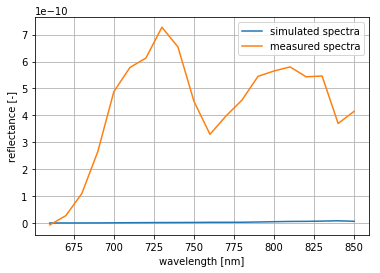

num: 2 | loss: 0.6879765044726648


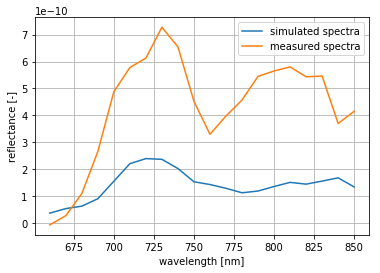

num: 4 | loss: 0.42516887322370295


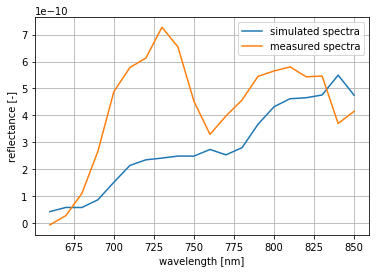

num: 20 | loss: 0.341717203081219


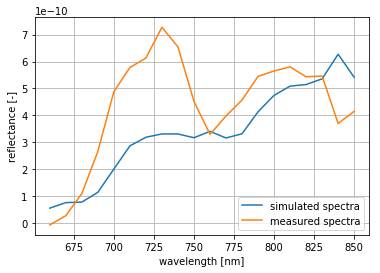

num: 28 | loss: 0.2775045217440846


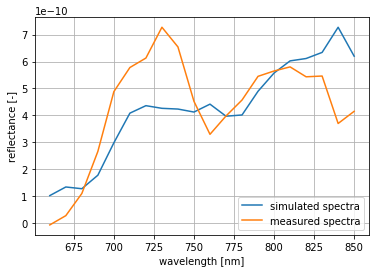

num: 980 | loss: 0.19409447404366115


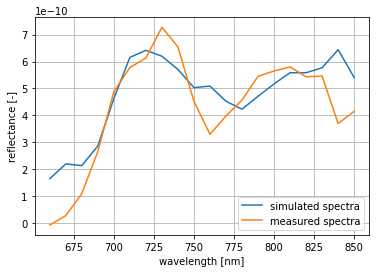

KeyboardInterrupt: 

In [241]:
# IJV收縮
loss = 100
for i, s in enumerate(s_max):
    if i in [979]:
        continue
    s = smooth(s[0, :20], 0.8)
    live = df["min"][:20]
    if np.sqrt((s-live)**2).mean()/df["min"].mean() < loss:
#     if True:
        loss = np.sqrt((s - live)**2).mean()/live.mean()
        print("num: {} | loss: {}".format(i, loss))
        
        plt.plot(wl[:20], s, label="simulated spectra") 
        plt.plot(wl[:20], live, label="measured spectra")
        plt.xlabel("wavelength [nm]")
        plt.ylabel("reflectance [-]")
        plt.legend()
        plt.grid()
        plt.show()

In [242]:
args[980]

{'skin': {'blood_volume_fraction': 0.07119307305150419,
  'ScvO2': 0.989892458754649,
  'water_volume': 0.6100111502780818,
  'fat_volume': 0.1790692030821044,
  'melanin_volume': 0.13972657358830953,
  'collagen_colume': 0},
 'fat': {'blood_volume_fraction': 0,
  'ScvO2': 0,
  'water_volume': 0,
  'fat_volume': 1,
  'melanin_volume': 0,
  'collagen_colume': 0},
 'muscle': {'blood_volume_fraction': 0.04314496327472474,
  'ScvO2': 0.9129422948260659,
  'water_volume': 0.8030184766076227,
  'fat_volume': 0,
  'melanin_volume': 0,
  'collagen_colume': 0.15383656011765257},
 'ijv': {'blood_volume_fraction': 1,
  'ScvO2': 0.6606205045171957,
  'water_volume': 0,
  'fat_volume': 0,
  'melanin_volume': 0,
  'collagen_colume': 0},
 'cca': {'blood_volume_fraction': 1,
  'ScvO2': 0.8593401215488585,
  'water_volume': 0,
  'fat_volume': 0,
  'melanin_volume': 0,
  'collagen_colume': 0}}

In [ ]:
# 一起比較
loss = 100
for i, (smax, smin) in enumerate(zip(s_max, s_min)):
    loss_ = (np.sqrt((smax[1,:]-df["min"])**2).mean()/df["min"].mean() + \
             np.sqrt((smin[1,:]-df["max"])**2).mean()/df["max"].mean()) / 2
    if loss_ < loss:
        
        loss = loss_
        print("num: {} | loss: {}".format(i, loss))
        
        plt.plot(wl, smax[1, :], label="simulated min") 
        plt.plot(wl, df["min"], label="measured min")
        
        plt.plot(wl, smin[1, :], label="simulated max") 
        plt.plot(wl, df["max"], label="measured max")
        
        plt.xlabel("wavelength [nm]")
        plt.ylabel("reflectance [-]")
        plt.legend()
        plt.grid()
        plt.show()

#### 單純比較形狀

2.271946693958749


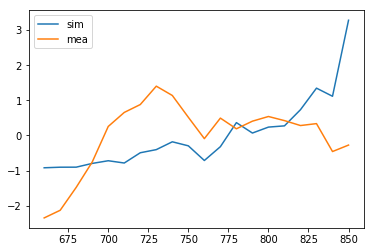

2.2424221898456347


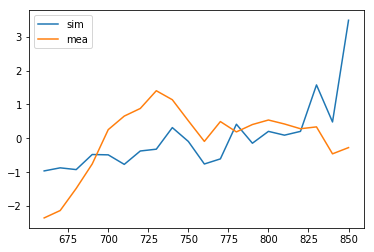

2.2379889904154995


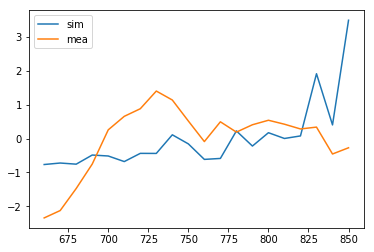

2.287019385290338


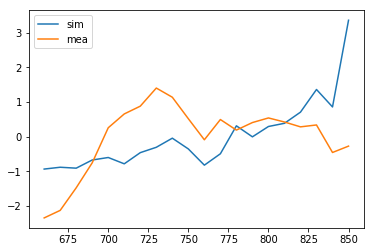

2.213240861995507


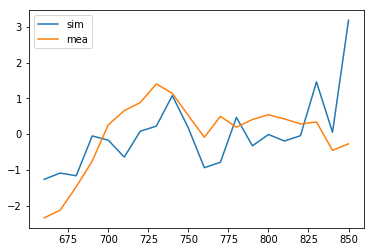

2.407422720393792


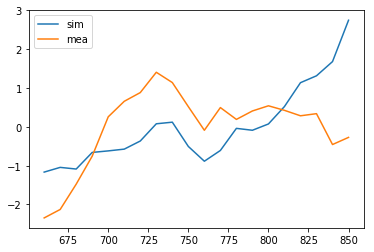

1.9669072904710159


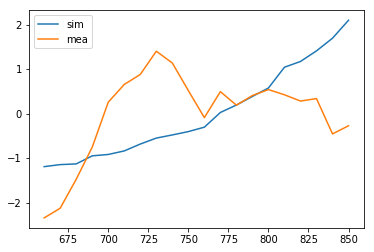

1.9771922085734406


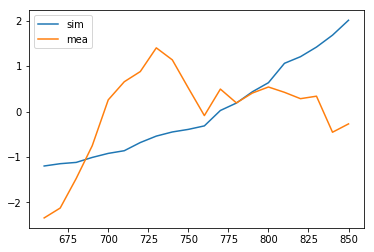

1.956064754016199


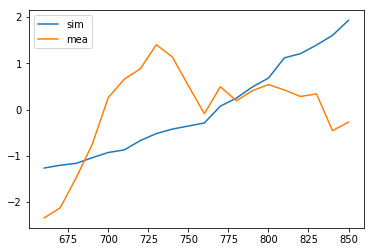

2.0542170745360546


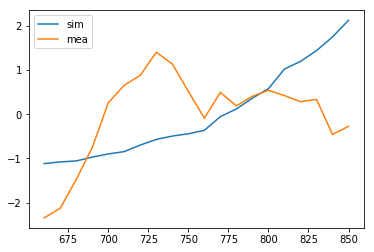

2.1914605030858256


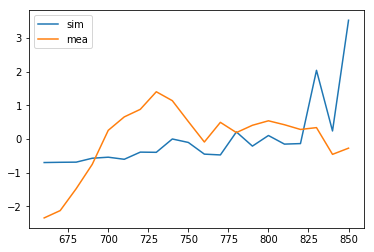

2.1779485305606925


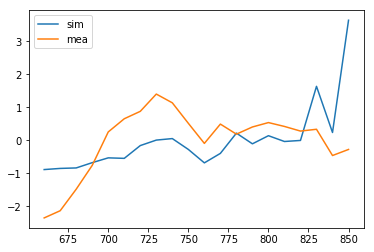

2.3999783894244477


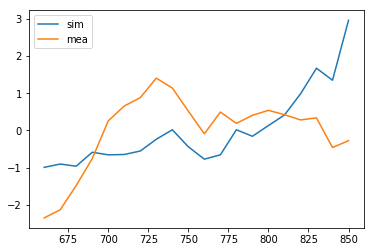

2.3347907573545763


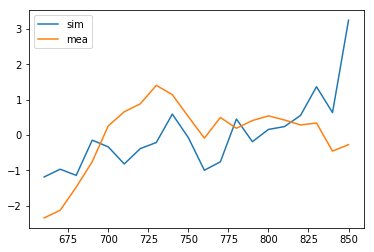

2.2436212236182653


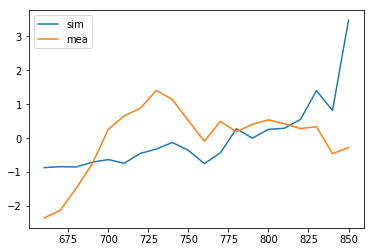

1.31093274779944


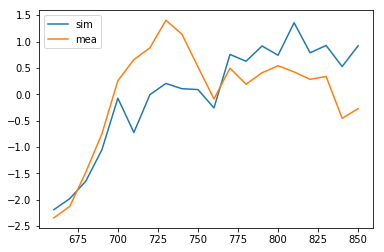

0.9903699976220223


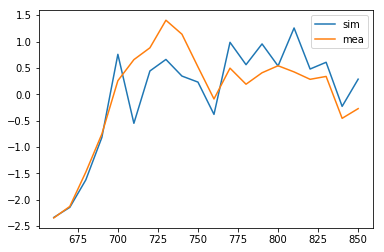

1.0540505034191754


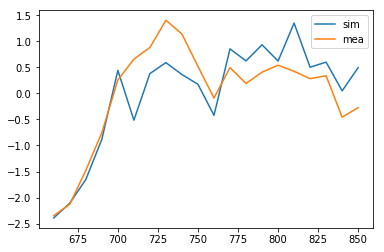

1.0126085125455013


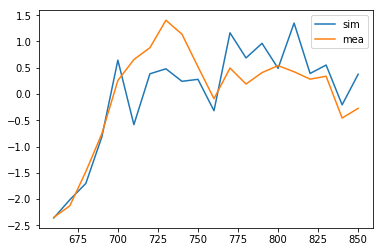

0.9124001202031919


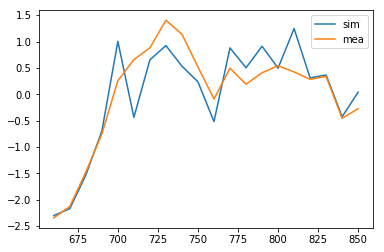

0.9216026046278595


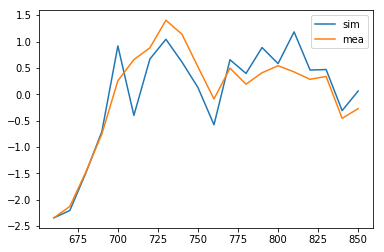

0.79591058104167


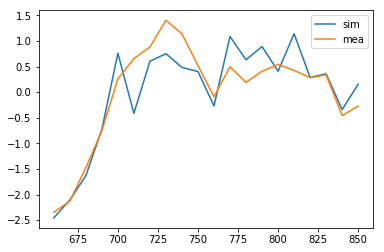

0.7976583547356138


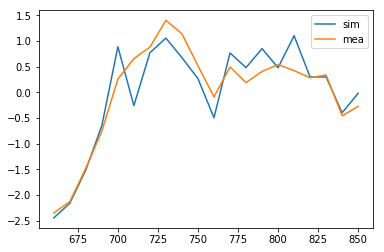

0.8544516788183729


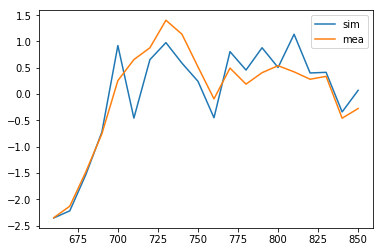

0.9506695966021539


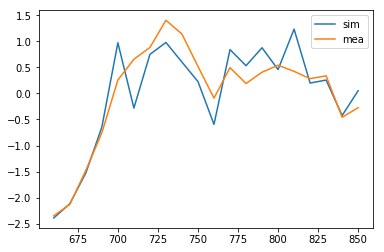

0.9367702334795937


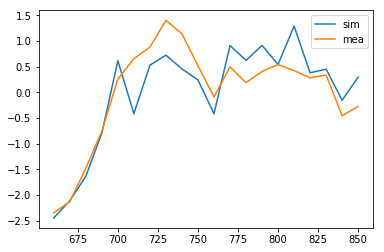

0.8848789219112726


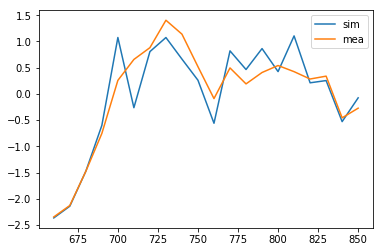

0.7890641135085676


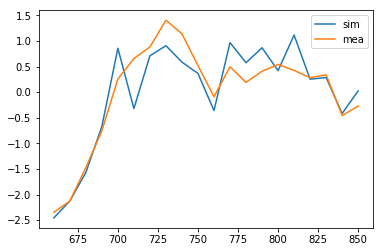

0.8252067945415789


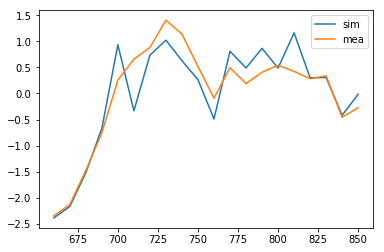

0.7572736826085251


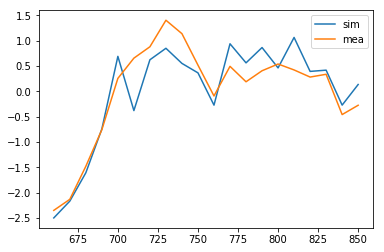

0.8207219630349891


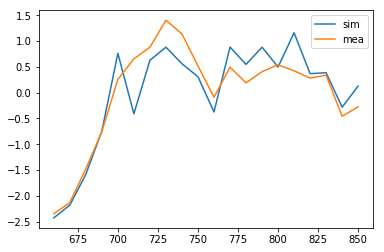

0.9648800865888664


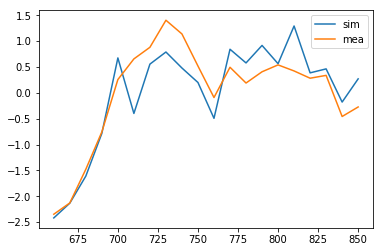

0.9103381740593331


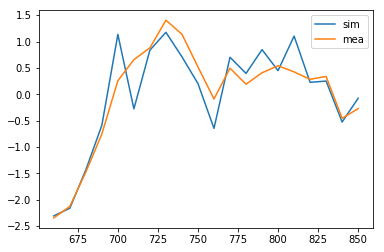

0.9388570253686312


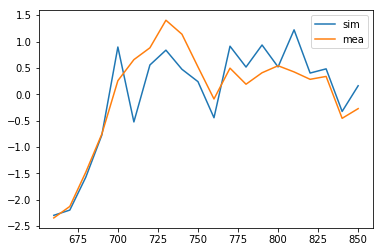

0.8088321977540245


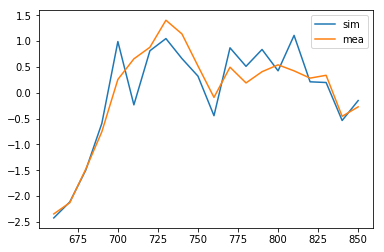

0.8428609181631413


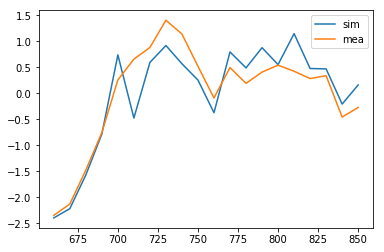

0.9371759798680264


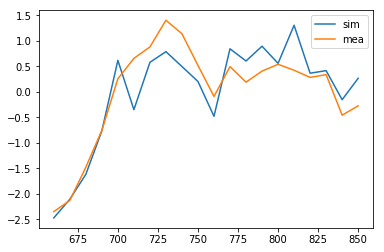

1.127732958990927


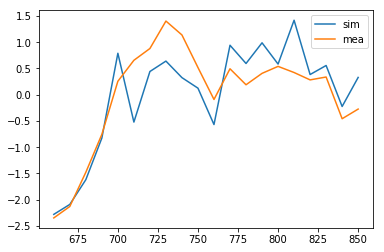

0.8427322573224034


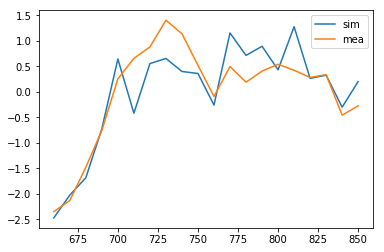

0.7949990477532342


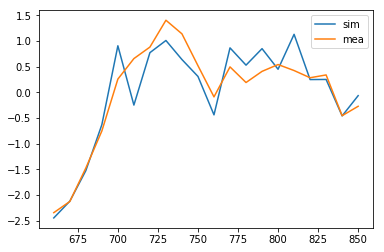

0.8199705013841341


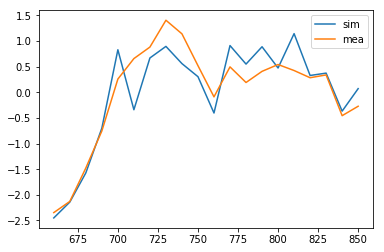

0.8551645818217996


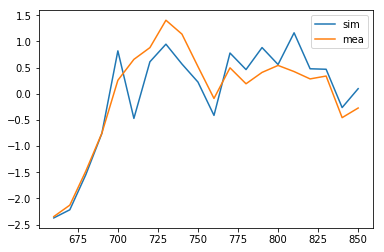

0.9689673470950874


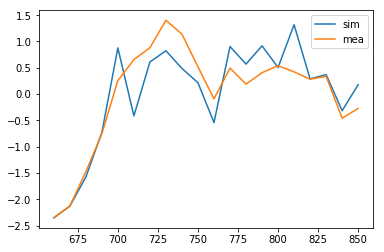

0.8142963298826051


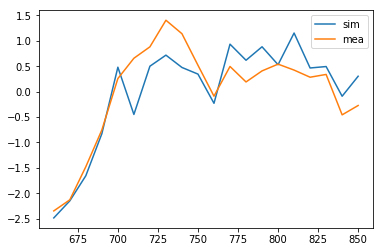

0.8609515481139678


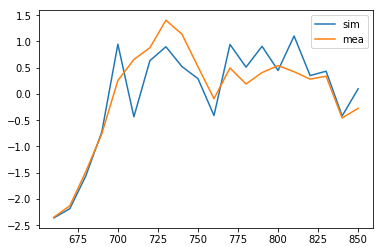

0.9770492521496774


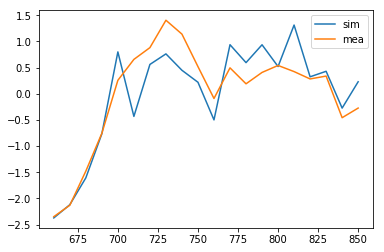

1.0643574426811402


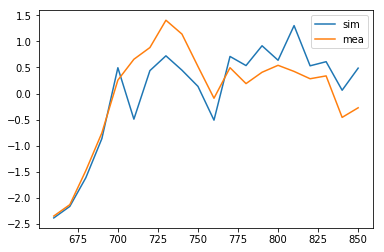

0.9416356911526099


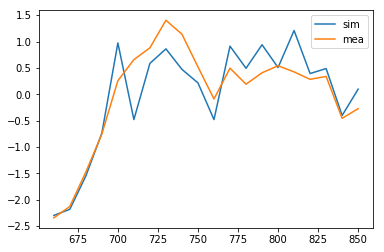

0.9137223380636919


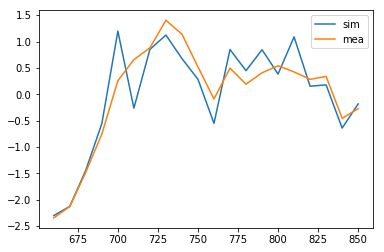

0.8322886010833084


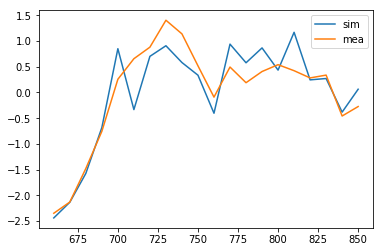

0.7666700459036966


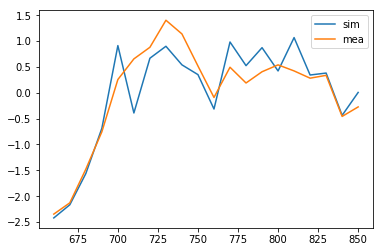

In [21]:
loss = 100
for s in s_max:
    s = (s - np.mean(s, 1, keepdims=True))/np.std(s, 1, keepdims=True)[:20]
    m = (df["min"][:20] - df["min"][:20].mean())/df["min"][:20].std()
    if np.sqrt(((s[0,:20]-m)/m)**2).mean() < loss:
        loss = np.sqrt(((s[1,:20]-m)/m)**2).mean()
        print(loss)
        plt.plot(wl[:20], s[1, :20], label="sim") 
        plt.plot(wl[:20], m, label="mea")
        plt.legend()
        plt.show()

2.0026494110711295


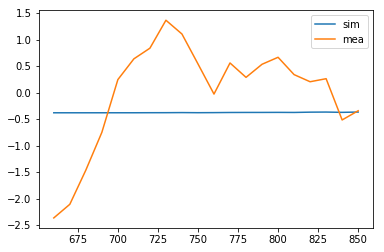

1.9820972893877264


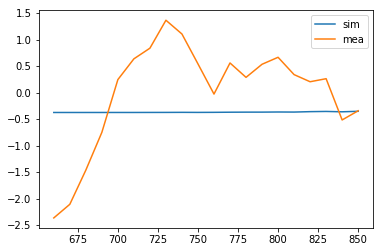

1.9806143929274014


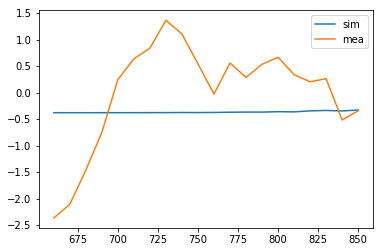

1.980375403866147


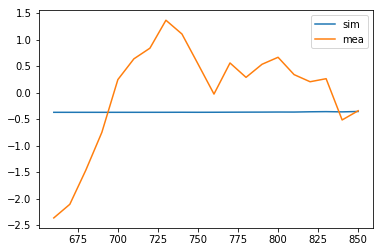

1.9692874246061716


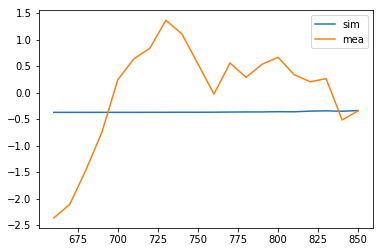

1.9664750548063163


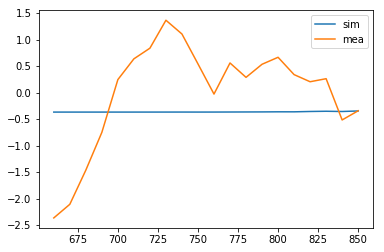

1.887100930166513


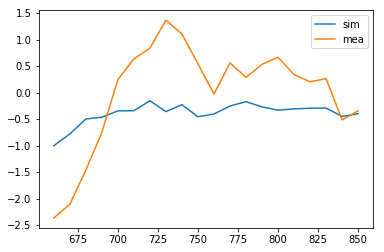

1.7669012312380956


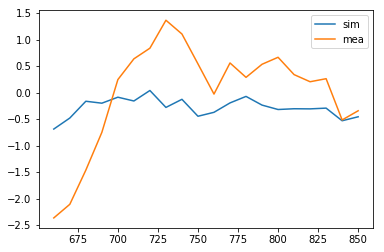

1.5862551928440825


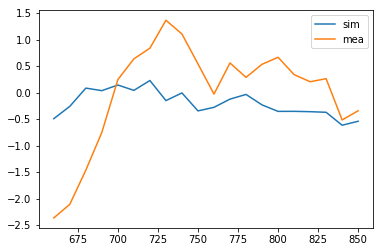

1.5278794950362564


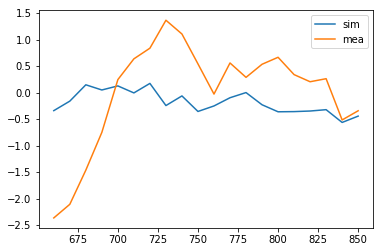

In [20]:
loss = 100
for s in s_min:
    s = (s - np.mean(s, 1, keepdims=True))/np.std(s, 1, keepdims=True)[:20]
    m = (df["max"][:20] - df["max"][:20].mean())/df["max"][:20].std()
    if np.sqrt(((s[0,:20]-m)/m)**2).mean() < loss:
        loss = np.sqrt(((s[0,:20]-m)/m)**2).mean()
        print(loss)
        plt.plot(wl[:20], s[0, :20], label="sim") 
        plt.plot(wl[:20], m, label="mea")
        plt.legend()
        plt.show()